In [17]:
from tqdm import tqdm

In [125]:
__author__ = 'm.bashari'
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt


class Config:
    nn_input_dim = 2  # input layer dimensionality
    nn_output_dim = 2  # output layer dimensionality
    # Gradient descent parameters (I picked these by hand)
    epsilon = 0.01  # learning rate for gradient descent
    reg_lambda = 0.01  # regularization strength


def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y


def visualize(X, y, model):
    # plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.show()
    plot_decision_boundary(lambda x:predict(model,x), X, y)
    plt.title("Logistic Regression")


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()


# Helper function to evaluate the total loss on the dataset
def calculate_loss(model, X, y):
    num_examples = len(X)  # training set size
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += Config.reg_lambda / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1. / num_examples * data_loss


def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)


# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(X, y, net_params, num_passes=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    num_examples = len(X)
    np.random.seed(0)

    W1 = np.asarray(net_params[0]['param']['W'])
    b1 = np.asarray(net_params[0]['param']['b'])
    W2 = np.asarray(net_params[1]['param']['W'])
    b2 = np.asarray(net_params[1]['param']['b'])
    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += Config.reg_lambda * W2
        dW1 += Config.reg_lambda * W1

        # Gradient descent parameter update
        W1 += -Config.epsilon * dW1
        b1 += -Config.epsilon * db1
        W2 += -Config.epsilon * dW2
        b2 += -Config.epsilon * db2

        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (i, calculate_loss(model, X, y)))
    return model

In [76]:
X, y = generate_data()
nn_hdim = 3
W1 = np.random.randn(Config.nn_input_dim, nn_hdim) / np.sqrt(Config.nn_input_dim)
b1 = np.zeros((1, nn_hdim))
W2 = np.random.randn(nn_hdim, Config.nn_output_dim) / np.sqrt(nn_hdim)
b2 = np.zeros((1, Config.nn_output_dim))

In [120]:
net_params = [{'type':'nn','param':{'W':W1.tolist(),'b':b1.tolist()}},
              {'type':'nn','param':{'W':W2.tolist(),'b':b2.tolist()}}]

In [140]:
net_params

[{'param': {'W': [[-0.33372573142803214,
     -0.2603474571907224,
     -0.00963828471352395],
    [0.8409012310991028, 1.697619268121154, -0.18905749203368508]],
   'b': [[-0.08501373899438408, -0.20727292165809735, 0.02769559503861578]]},
  'type': 'nn'},
 {'param': {'W': [[0.02080696025277029, -1.144103113664622],
    [0.8488184316301368, -1.949295383418296],
    [-0.2708987593903307, -0.0699401386142649]],
   'b': [[0.05263546500057166, -0.052635465000571716]]},
  'type': 'nn'}]

Loss after iteration 0: 0.318544


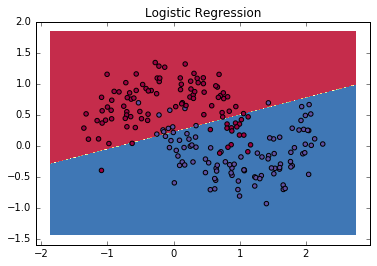

In [143]:
model = build_model(X, y, net_params, num_passes=1, print_loss=True)
visualize(X, y, model)

In [144]:
net_params

[{'param': {'W': [[-0.33372573142803214,
     -0.2603474571907224,
     -0.00963828471352395],
    [0.8409012310991028, 1.697619268121154, -0.18905749203368508]],
   'b': [[-0.08501373899438408, -0.20727292165809735, 0.02769559503861578]]},
  'type': 'nn'},
 {'param': {'W': [[0.02080696025277029, -1.144103113664622],
    [0.8488184316301368, -1.949295383418296],
    [-0.2708987593903307, -0.0699401386142649]],
   'b': [[0.05263546500057166, -0.052635465000571716]]},
  'type': 'nn'}]

In [137]:
import json
_dump = json.dumps(net_params)

In [139]:
with open('dump.json','wb') as f:
    f.write(_dump)